## Self-Driving Car Engineer Nanodegree - Deep Learning Module:
###  Dean Webb's "WebbNet" Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

---

### Step 1: Dataset Exploration - Summary

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!

##### <font color='red'> Question 1 - Done</font> ###

**_Describe the techniques used to preprocess the data._**

** <font color='blue'> Answer: </font> ** The main technique that I am thrilled to report is that I was able to successfully download and preprocess the raw image files straight from the German Traffic Sign Classifier Benchmark source: "http://benchmark.ini.rub.de/Dataset/" (347 MB). This allows me to much more flexibility for preprcoessing. for example, I can change the resolution of all images that feed into my network by simply changing the "DEFAULT_RESOLUTION" tuple in my constants section below. Further, I can similarly utilize localization in the image by crop the image to the size of the bounding box. A combination of resizing and cropping hopefully will help to reduce (or introduce) noise in my dataset.

Lastly, I serialized and cached the dataset into a pickle file, utilizing the helper function provided. This is done by setting the refresh_datacache=True. The pickled data is a dictionary with 4 key/value pairs:
- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

##### <font color='red'> Question 2 - Done</font> ###

**_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_**

** <font color='blue'> Answer:</font> ** I wanted to really test out my the preprocessing of the RAW images vs the Udacity provided dataset, so I introduced a flag "use_raw_dataset" that alternates between the two datasets. I note that this flag is used in combination with the flag above in my "load_datasets" function to produce the following outcomes:
    
**<font color='blue'>use_raw_dataset=True, refresh_datacache=True</font>**  
    - Starts preprocessing from scratch utilizing the raw dataset Downloads from source, preprocesses, overwrites the datacache

**<font color='blue'>use_raw_dataset=True, refresh_datacache=False</font>**
    - Restores the dataset from the datacache. (Note, the refresh_datacache flag takes precedence, so if the flag is set to false. It uses the datacache currently stored with no preference to the source! This can be accomplished by including a "datasource" flag into the datacache) 

**<font color='blue'>use_raw_dataset=False, refresh_datacache=True</font>**
    - Starts preprocessing from scratch utilizing the Udacity dataset
    
**<font color='blue'>use_raw_dataset=False, refresh_datacache=False</font>**
    - Restores dataset from the datacache. (Note, the refresh_datacache flag takes precedence, so if the flag is set to false. It uses the datacache currently stored with no preference to the source! This can be accomplished by including a "datasource" flag into the datacache)

### Validation_Set Child Dataset Object of Training_Set
Here's an exmple Dataset onject used for validation:
" Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f22144599e8>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classified labelnames vector length: (43, 2)
Training_Set_Raw_PPM | Validation_Set | Number of image examples in the set: 3920

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 58.0% (2275 / 3920)
Iter:      0, Train-Batch Avg Accuracy:  38.1%, Validation Accuracy:  58.0% **
epoch: 0001 mini-batch iteration: 0000 cost= 1.915154 accuracy= 0.550000
epoch: 0001 mini-batch iteration: 0100 cost= 1.577182 accuracy= 0.680000
epoch: 0001 mini-batch iteration: 0200 cost= 1.579299 accuracy= 0.630000
epoch: 0001 mini-batch iteration: 0300 cost= 1.161258 accuracy= 0.830000
epoch: 0001 avg_cost= 1.461790 avg_accuracy= 0.689365

### Process Multiple Datasources Autonomously: RAW (ppm) images vs. PreProcessed Image Cache Comparison

In order to get the raw (ppm) images processed, I use flags to filters between Source Images and Udacity Provided Dataset (as shown above). However, all datasets could be loaded autonamtically as well. The data sets are dynamically loaded into memory by some helper functions I made:
    - Preprocessing Engine
    - DataSet object
    - Optimization Instructor

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import gzip
import urllib
import zipfile
import glob
from PIL import Image
import csv
import matplotlib.image as mpimg
import pickle
import shutil

### Constants

In [2]:
# Dataset Extraction
DE_TRAFFIC_SIGNS_SOURCE_URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/'
GTSRB_SOURCE_URL = 'http://benchmark.ini.rub.de/Dataset/'

# Image Processing
DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH = (32, 32, 3)
DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH) if DEFAULT_DEPTH > 1 else (DEFAULT_LENGTH, DEFAULT_WIDTH)
DEFAULT_IMG_EXTENSION = '.ppm'
DATASET_DIRECTORY = 'traffic-signs-data/'
DATACACHE_DIRECTORY = 'datacache/'
PRE_PROCESSED_ZIP = 'traffic-signs-data.zip'

# Training Dataset
TRAINING_SET_RAW_PPM = 'Training_Set_Raw_PPM'
TRAINING_SET_UDACITY = 'Training_Set_Udacity_Dict'
TRAIN_IMAGES_ZIP = 'GTSRB_Final_Training_Images.zip'
TRAIN_IMAGES_DIR = 'GTSRB/Final_Training/Images'

# Validation Dataset
VALIDATION_PORTION = 0.10 #Percentage of training_set reserved for the validation_set, used during auto-optimization.

# Testing Dataset
TESTING_SET_RAW_PPM = 'Testing_Set_Raw_PPM'
TESTING_SET_UDACITY = 'Testing_Set_Udacity_Dict'
TEST_IMAGES_ZIP = 'GTSRB_Final_Test_Images.zip'
TEST_IMAGES_DIR = 'GTSRB/Final_Test/Images'
TEST_LABELS_ZIP = 'GTSRB_Final_Test_GT.zip'
TESTING_LABELS_CSV = 'GT-final_test.csv'

# Custom Testing Dataset
CUSTOM_TESTING_SET_RAW_PPM = 'Custom_Testing_Set_Raw_PPM'
CUSTOM_TEST_IMAGES_ZIP = 'resources_Custom_Set_Images.zip'
CUSTOM_TEST_IMAGES_DIR = 'resources/Custom_Set/Images'
CUSTOM_TESTING_LABELS_CSV = 'custom_set_annotations.csv'

CLASSIFIED_LABELS_CSV = 'signnames.csv'

### Helper Module: Preprocessing Engine: 
Module for downloading, extracting, processing, and loading the Datasets. Currently supports multiple datasets that can function as a training_Set with a validation subset, or a testing_set with a classify_test_set function. 
- The pre-processed, Udacity provided dataset from "https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip"    (121 MB)

- And the corresponding raw data set from http://benchmark.ini.rub.de/Dataset/ (347 MB)

In [3]:
def maybe_download(filename, work_directory, use_raw_dataset=True):
    filepath = os.path.join(work_directory, filename)
    if use_raw_dataset:
        SOURCE_URL = GTSRB_SOURCE_URL
    else:
        SOURCE_URL = DE_TRAFFIC_SIGNS_SOURCE_URL

    if not os.path.exists(work_directory):
        os.mkdir(work_directory)
        filepath = os.path.join(work_directory, filename)
    if not os.path.exists(os.path.join(work_directory, filename)) or not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        statinfo = os.stat(filepath)
        print('')
        print('Succesfully downloaded:', filepath, '| % d MB.' % int(statinfo.st_size*1e-6))
    return filepath

def _read32(bytestream):
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)

def unzip_file(source, new_filename, destination):
    root, ext = os.path.splitext(new_filename)
    if not os.path.exists(os.path.join(destination, new_filename)) or (len(ext) > 0):
        print('File does not exist: ', os.path.join(destination, new_filename), ': Extracting')
        zipf = zipfile.ZipFile(os.path.join(source,new_filename))
        print('Loaded zipf',zipf, ': Extracting')
        zipf.extractall(destination)
        zipf.close()

def read_csv(filepath, num_features = (8), delimiter=';', label_column=7):
    data_array = np.array(np.zeros(shape=num_features))
    with open(filepath, newline='') as csvfile:
        annotations_reader = csv.reader(csvfile, delimiter=delimiter, quotechar='|')
        for row in annotations_reader:
            if row[label_column].isdigit():
                data_array = np.vstack((data_array, np.array(row)))
    return data_array[1:]

# Optionally returns a list of images of corresponding filepaths
def resize_images(filepaths, return_data=True):
    # TODO: Add cropping from bounding box
    images = []
    labels = [] if return_data else None
    file_names = np.array(np.zeros(shape=(1)))

    for current_img in filepaths:
        if os.path.exists(current_img) and DEFAULT_IMG_EXTENSION in current_img:
            img = Image.open(current_img)
            if img.mode != 'RGB':
                img = img.convert('RGB')
                img.save(current_img)
            if ((img.size) != (DEFAULT_LENGTH, DEFAULT_LENGTH)):
                img = img.resize(DEFAULT_RESOLUTION[0:2], Image.ANTIALIAS)
            img.save(current_img)
            img.close()
            images.extend([mpimg.imread(str(current_img))])
            split_paths = os.path.split(current_img) 
            label_path = os.path.split(split_paths[0])[1]
            if return_data and label_path.isdigit() and len(label_path) == 5:
                labels.extend([int(label_path)])
                np.vstack((file_names, np.array(split_paths[1])))
            else:
                file_names = np.vstack((file_names, split_paths[1]))
        else:
            print("File {0} is not an image with extension: {1}! Skipping..".format(
                  current_img, DEFAULT_IMG_EXTENSION))
    if return_data:
        return (np.array(images), np.reshape(file_names[1:], (-1)), labels)
    
def extract_label_names():
    annotations = read_csv(os.path.join(CLASSIFIED_LABELS_CSV), num_features = (2), delimiter=',', label_column=0)
    return annotations

def exclude_hidden_files(path):
    return glob.glob(os.path.join(path, '*'))

def extract_preprocessed_data(filename, work_directory):
    if not os.path.exists(work_directory):
        os.mkdir(work_directory)
    datacache_directory = os.path.join(work_directory, DATACACHE_DIRECTORY)
    if not os.path.exists(datacache_directory):
        os.mkdir(datacache_directory)
    head, tail = os.path.split(filename)
    print('unzipping file:', tail, 'to directory:', datacache_directory)
    unzip_file(head, tail, datacache_directory)
    return datacache_directory

def extract_training_data(filename, work_directory, images_path):
    #Unzip File
    head, tail = os.path.split(filename)
    print('unzipping file:', tail, 'to directory:', work_directory)
    unzip_file(head, tail, work_directory)
        
    #Traverse Directories and load Dataset
    images_path_dir = os.listdir(os.path.join(work_directory, images_path))
    label_array = []
    filename_array = []
    data = np.array([np.zeros(shape=DEFAULT_RESOLUTION)])
    for label_path in images_path_dir:
        working_dir= os.path.join(work_directory, images_path, label_path)

        if os.path.exists(os.path.join(working_dir, '/')):
            filenames = np.array([os.path.join(working_dir, path) for path
                           in os.listdir(working_dir) if DEFAULT_IMG_EXTENSION in path
                                  and ")" not in path and "(" not in path 
                                  and os.path.exists(os.path.join(working_dir, path))])         
            images_batch, filenames_batch, labels_batch = resize_images(filenames)
            if images_batch.shape[1:] == DEFAULT_RESOLUTION:
                data = np.vstack((data, images_batch))
            filename_array.extend(filenames_batch)
            label_array.extend(labels_batch)

    return (data[1:], label_array, filename_array)
        
def extract_testing_data(filename, work_directory, images_path):
    #Unzip File
    head, tail = os.path.split(filename)
    print('unzipping file:', tail, 'to directory:', work_directory)
    unzip_file(head, tail, work_directory)

    #Extract testing labels from TESTING_LABELS_CSV
    local_test_label_path = maybe_download(TEST_LABELS_ZIP, work_directory)
    if not os.path.exists(os.path.join(work_directory, images_path, TESTING_LABELS_CSV)):
        print('File does not exist: ', os.path.join(work_directory, images_path, TESTING_LABELS_CSV), ': Extracting')
        zipf = zipfile.ZipFile(local_test_label_path)
        print('Loaded zipf',zipf, ': Extracting')
        zipf.extractall(os.path.join(work_directory, images_path))
        zipf.close()
    annotations = read_csv(os.path.join(work_directory, images_path, TESTING_LABELS_CSV))
    
    #Traverse Directories and load Dataset
    images_path = exclude_hidden_files(os.path.join(work_directory, images_path))
    data = [np.array(np.zeros(shape=DEFAULT_RESOLUTION))]
    filenames = np.array([path for path
                           in images_path if DEFAULT_IMG_EXTENSION in path
                                  and ")" not in path and "(" not in path and os.path.exists(path)])
    images_batch, filenames_batch, _ = resize_images(filenames, return_data=True)
    labels_batch = np.array([int(label) for label in annotations[:,7] if np.chararray.isdigit(label)])
    
    #Load Labels from filename
    labels = np.array(np.zeros(shape=(1)))
    for filename in filenames_batch:
        label_index = np.nonzero( annotations[:,0] == filename) 
        label = annotations[:,7][label_index]
        labels= np.vstack((labels, label))
    
    return (images_batch, np.reshape(labels[1:], (-1)), filenames_batch)

def extract_custom_testing_data(filename, work_directory, images_path):
    #Unzip File
    head, tail = os.path.split(filename)
    print(head, 'unzipping file:', tail, 'to directory:', work_directory)
    unzip_file(head, tail, work_directory)

    annotations = read_csv(os.path.join(work_directory, images_path, CUSTOM_TESTING_LABELS_CSV),
                           num_features = (2), delimiter=',', label_column=1)
    
    #Walk Directories and load Dataset
    images_path = exclude_hidden_files(os.path.join(work_directory, images_path))
    data = [np.array(np.zeros(shape=DEFAULT_RESOLUTION))]
    filenames = np.array([path for path
                           in images_path if DEFAULT_IMG_EXTENSION in path
                                  and ")" not in path and "(" not in path and os.path.exists(path)])
    images_batch, filenames_batch, _ = resize_images(filenames, return_data=True)
    labels_batch = np.array([int(label) for label in annotations[:,1] if np.chararray.isdigit(label)])
    
    #Load Labels from filename
    labels = np.array(np.zeros(shape=(1)))
    for filename in filenames_batch:
        label_index = np.nonzero( annotations[:,0] == filename) 
        label = annotations[:,1][label_index]
        labels= np.vstack((labels, label))
    
    return (images_batch, np.reshape(labels[1:], (-1)), filenames_batch)

def restore_from_datacache(datacache_dir):
    training_file = os.path.join(datacache_dir,"train.p")
    testing_file = os.path.join(datacache_dir, "test.p") 
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    X_test, y_test = test['features'], test['labels']
    X_name, y_name = train['name'], test['name']
    
    if train['validation_set'] is not None or train['validation_set'] != {}:
        X_train, X_validate, y_train = train['features'], train['validation_set'], train['labels']
        return (X_train, X_validate, y_train, X_test, y_test, X_name, y_name)
    else:
        X_train, y_train = train['features'], train['labels']
        return (X_train, _, y_train, X_test, y_test, X_name, y_name)

def overwrite_datacache(training_set, testing_set, datacache_dir):
    if os.path.exists(datacache_dir):
        shutil.rmtree(datacache_dir, ignore_errors=True)
    os.mkdir(datacache_dir)
    training_file = os.path.join(datacache_dir,"train.p")
    testing_file = os.path.join(datacache_dir, "test.p") 
    if training_set.validation_set is not None or training_set.validation_set == training_set.validation_set:
        train = { 'name': training_set.name, 'features': training_set.images, 'labels': training_set.labels, 
             'validation_set': training_set.validation_set }
    else:
        train = { 'name': training_set.name, 'features': training_set.images, 'labels': training_set.labels }
    test = { 'name': testing_set.name, 'features': testing_set.images, 'labels': testing_set.labels }
    pickle.dump(train, open(training_file, "wb"))
    pickle.dump(test, open(testing_file, "wb"))

### Helper Class: Generic Dataset  
Helper class for storing an array of Dataset used for processessing. The Datasets are loaded after all of the files are preprocessed (downloaded, extracted, processed. Currently supports any generic dataset, provided the images follow the same directory structure. Below, I used the raw test-set collected from the site and used a mini-batch test_set of 100 hand selected imaged from Google. Those images were screen-captured from Google images and loaded in a directory similar to the GTSRB structure. 

I also attempted to find a distribution in this sample set to get a good sample size.  datasets that can function as a training_Set with a validation subset, or a testing_set with a classify_test_accuracy. 

In [4]:
class DataSet(object):
    def __init__(self, images, labels, filenames, labelnames, name='Training_Set',
                 validation_portion = 0.0, validation_set=None):
        images = images.astype(np.float32)
        labels = labels.astype(np.int_)
        
        if validation_set is not None or validation_portion > 0.0:
            self._validation_set = validation_set
        else:
            self._validation_set = None
            images = np.multiply(images, 1.0 / 255.0) # Scale on first load to help with normalization. 
        if filenames.shape[0] == 0:
            filenames = np.array(np.zeros_like(labels))
        if labelnames.shape[0] == 0:
            labelnames = np.array(np.zeros_like(labels))
            
        self._num_examples = len(images)
        self._images = images
        self._labels = labels  
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._avg_training_accuracy = 0.0
        self._validation_accuracy = 0.0
        self._filenames = filenames
        self._labelnames = labelnames
        self._name = name
        
        #Shuffle Data
        perm = np.arange(self._num_examples)
        np.random.shuffle(perm)
        self._images = self._images[perm]
        self._labels = self._labels[perm]
        self._filenames = self._filenames[perm]
        
        if validation_portion > 0.0: # This variable overwrites the validation
            self._validation_set = self.create_validation_set(validation_portion=validation_portion)
        
        self.print_loading_report()
        
    @property
    def images(self):
        return self._images
    @property
    def name(self):
        return self._name
    @property
    def filenames(self):
        return self._filenames
    @property
    def labelnames(self):
        return self._labelnames
    @property
    def labels(self):
        return self._labels    
    @property
    def num_examples(self):
        return self._num_examples
    @property
    def epochs_completed(self):
        return self._epochs_completed
    @property
    def iterations_completed(self):
        return self.iterations_completed
    @property
    def is_optimized(self):
        return self._is_optimized
    @property
    def avg_training_accuracy(self):
        return self._avg_training_accuracy
    @property
    def validation_accuracy(self):
        return self._validation_accuracy
    @property
    def validation_set(self):
        if self._validation_set is None:
            _validation_set = self.create_validation_set()
        return self._validation_set
    
    def set_training_accuracy(self, avg_training_accuracy):
        self._avg_training_accuracy = avg_training_accuracy

    def set_validation_accuracy(self, validation_accuracy):
        self._validation_accuracy = validation_accuracy
    
    def create_validation_set(self, validation_portion=.10):
        #Create validation set from training_set based on validation_portion.
        assert validation_portion < 1.0
        validation_size = int(self._num_examples*validation_portion)
        self._validation_size = validation_size
        self._num_examples = self._num_examples - self._validation_size
        
        validation_size = validation_size*-1
        images = self._images[validation_size:]
        self._images = self._images[:validation_size]
        labels = self._labels[validation_size:]
        self._labels = self._labels[:validation_size]
        filenames = self._filenames[validation_size:]
        self._filenames = self._filenames[:validation_size]
            
        return {'images': images, 'labels': labels, 'filenames': filenames,
                'num_examples': -1*validation_size}
    
    def print_validation_report(self, show_example_images=True):
        print(self._name, '|', 'validation_set[\'images\'] shape:', self._validation_set['images'].shape)
        print(self._name, '|', 'validation_set[\'labels\'] shape:', self._validation_set['labels'].shape)
        print(self._name, '|', 'validation_set[\'filenames\'] shape:', self._validation_set['filenames'].shape)
        print(self._name, '|', 'validation_set[\'num_examples\'] shape:', self._validation_set['num_examples'])
        validation_imgs = self._validation_set['images']
        if show_example_images:
            self.plot_images(images=validation_imgs[:9])
    
    def next_batch(self, batch_size, with_label = False):
        #Return the next `batch_size` examples from this Dataset.
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            self._filenames = self._filenames[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        if with_label == True:
            return self._images[start:end], self._labels[start:end]
        return self._images[start:end]
    
    def get_labelname(self, label_id):
        return self._labelnames[label_id][1]
    
    def distort_batch(self, batch):
        #TODO: Fix distort_batch (return statements from above)
                    #return self.distort_batch(self._images[start:end]), self._labels[start:end], self._filenames[start:end]
        #return self.distort_batch(self._images[start:end])
        
        batch_size = len(batch)
        row_distort = np.random.randint(0, 3, batch_size)
        col_distort = np.random.randint(0, 3, batch_size)
        result = np.zeros(shape=(batch_size, DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH), dtype=np.float32)
        for i in range(batch_size):
            result[i, :, :, :] = batch[i, row_distort[i]:row_distort[i]+DEFAULT_LENGTH, col_distort[i]:col_distort[i]+DEFAULT_WIDTH, :]
        return result

    def plot_images(self, cls_pred=None, images=None):
        if images is None:
                images=self.images[:9]
        else:
            images=images
                
        # Create figure with 3x3 sub-plots.
        fig, axes = plt.subplots(3, 3)
        multiplier = 1.1
        fig.subplots_adjust(hspace=2.0*multiplier, wspace=3.5*multiplier)

        for i, ax in enumerate(axes.flat):
            #TODO: Fix scaling issue in restore datacache (Scaled down during Dataset initialization.
            #images = np.multiply(images, 255.0)

            # Plot image.
            ax.imshow(images[i])

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "Actual: {0:.20}".format(self.get_labelname(self._labels[i]))
            else:
                xlabel = "Pred: {0:.19} \nTrue: {1:.19}".format(self.get_labelname(cls_pred[i]),self.get_labelname(self._labels[i]))

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)

            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()
    
    def show_example_images(self):        
        self.plot_images()
    
    def shuffle_data(self):
        perm = np.arange(self._num_examples)
        np.random.shuffle(perm)
        self._images = self._images[perm]
        self._labels = self._labels[perm]
        self._filenames = self._filenames[perm]
        
    def print_loading_report(self):
        print('')
        print('Dataset: "', self._name,'" successfully loaded to memory location:', self)
        print(self._name,'|', "Images tensor shape:", self.images.shape)
        print(self._name,'|', "Labels vector length:",self.labels.shape)
        print(self._name,'|', "Number of image filenames vector length:",self.filenames.shape)
        print(self._name,'|', "Number of classified labelnames vector length:",self.labelnames.shape)
        print(self._name,'|', "Number of image examples in the set:",self.num_examples)
        assert self.images.shape[0] == self.labels.shape[0], "The images/labels must match in the Dataset!\n"
    
        self.show_example_images()
        
        #Print Validation dimensions if validation_set
        if self._validation_set is not None and self._validation_set != {}:
            self.print_validation_report(show_example_images=True)        
        print('Loading report for',self._name,'concluded.')

    def load_datasets(use_raw_dataset=True, refresh_datacache=True):
        working_dir = DATASET_DIRECTORY
        datacache_dir = os.path.join(working_dir, DATACACHE_DIRECTORY)
        labelnames = extract_label_names()
        
        cust_test_images, cust_test_labels, cust_test_filenames = extract_custom_testing_data(
            CUSTOM_TEST_IMAGES_ZIP, working_dir, CUSTOM_TEST_IMAGES_DIR)
        custom_testing_set = DataSet(cust_test_images, cust_test_labels, cust_test_filenames,
                                     labelnames, name=CUSTOM_TESTING_SET_RAW_PPM)
        
        #Determine which Datasets to load    
        if use_raw_dataset:
            if  refresh_datacache:
                # Extract Training Data
                local_path = maybe_download(TRAIN_IMAGES_ZIP, working_dir, use_raw_dataset=True)
                train_images, train_labels, train_filenames = extract_training_data(local_path, working_dir,
                                                                                    TRAIN_IMAGES_DIR)
                # Extract Testing Data
                local_path = maybe_download(TEST_IMAGES_ZIP, working_dir, use_raw_dataset=True)
                test_images, test_labels, test_filenames = extract_testing_data(local_path, working_dir,
                                                                                TEST_IMAGES_DIR)
                # Load Datasets
                training_set = DataSet(train_images, np.array(train_labels), np.array(train_filenames), labelnames, 
                                       validation_portion = VALIDATION_PORTION, name=TRAINING_SET_RAW_PPM)
                testing_set = DataSet(test_images, test_labels, test_filenames, labelnames, name=TESTING_SET_RAW_PPM) 
                # Overwrite Pickle File
                overwrite_datacache(training_set, testing_set, datacache_dir)
            else:
                # Extract Dataset from Pickle file
                train_images,validation_set,train_labels,test_images,test_labels,train_name,test_name = restore_from_datacache(
                    datacache_dir)
                train_filenames, test_filenames = (np.array([]), np.array([]))
                # Load Datasets
                training_set = DataSet(train_images, train_labels, train_filenames, labelnames, name=train_name,
                                       validation_portion=VALIDATION_PORTION, validation_set=validation_set)
                testing_set = DataSet(test_images, test_labels, test_filenames, labelnames, name=train_name,)
        elif refresh_datacache:
            # Remove Datacache
            if os.path.exists(datacache_dir):
                shutil.rmtree(datacache_dir, ignore_errors=True)
                os.mkdir(datacache_dir)
            # Extract Preprocessed Data   
            local_path = maybe_download(PRE_PROCESSED_ZIP, working_dir, use_raw_dataset=False)
            datacache_dir = extract_preprocessed_data(local_path, working_dir)
            train_images,validation_set,train_labels,test_images,test_labels,_,_ = restore_from_datacache(
                datacache_dir)
            train_filenames, test_filenames = (np.array([]), np.array([]))
            # Load Datasets
            training_set = DataSet(train_images, train_labels, train_filenames, labelnames, name=TRAINING_SET_UDACITY,
                                   validation_portion = VALIDATION_PORTION, validation_set=validation_set)
            testing_set = DataSet(test_images, test_labels, test_filenames, labelnames, name=TESTING_SET_UDACITY)
            overwrite_datacache(training_set, testing_set, datacache_dir)
        else:
            # Extract Dataset from Pickle file
            train_images,validation_set,train_labels,test_images,test_labels,train_name,test_name = restore_from_datacache(
                datacache_dir)
            train_filenames, test_filenames = (np.array([]), np.array([]))
            # Load Datasets
            training_set = DataSet(train_images, train_labels, train_filenames, labelnames, name=train_name,
                                   validation_portion = VALIDATION_PORTION, validation_set=validation_set)
            testing_set = DataSet(test_images, test_labels, test_filenames, labelnames, name=test_name)
            
        return (training_set, [testing_set, custom_testing_set])


# Load DataSets and Report Data Dimensions
The data dimensions are used in several places in the model below. They are defined once so we can use these variables instead of numbers throughout the code.

 unzipping file: resources_Custom_Set_Images.zip to directory: traffic-signs-data/
File does not exist:  traffic-signs-data/resources_Custom_Set_Images.zip : Extracting
Loaded zipf <zipfile.ZipFile filename='resources_Custom_Set_Images.zip' mode='r'> : Extracting

Dataset: " Custom_Testing_Set_Raw_PPM " successfully loaded to memory location: <__main__.DataSet object at 0x7f99ac4493c8>
Custom_Testing_Set_Raw_PPM | Images tensor shape: (100, 32, 32, 3)
Custom_Testing_Set_Raw_PPM | Labels vector length: (100,)
Custom_Testing_Set_Raw_PPM | Number of image filenames vector length: (100,)
Custom_Testing_Set_Raw_PPM | Number of classified labelnames vector length: (43, 2)
Custom_Testing_Set_Raw_PPM | Number of image examples in the set: 100


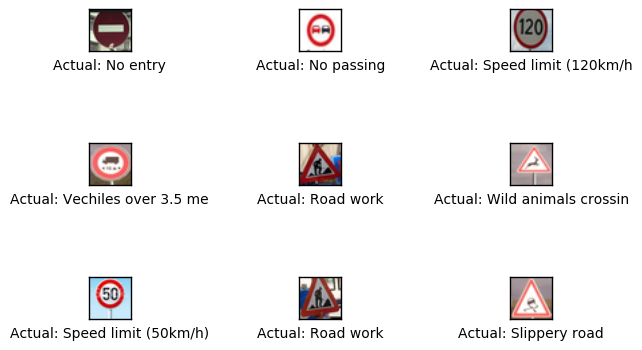

Loading report for Custom_Testing_Set_Raw_PPM concluded.

Succesfully downloaded: traffic-signs-data/GTSRB_Final_Training_Images.zip |  276 MB.
unzipping file: GTSRB_Final_Training_Images.zip to directory: traffic-signs-data/
File does not exist:  traffic-signs-data/GTSRB_Final_Training_Images.zip : Extracting
Loaded zipf <zipfile.ZipFile filename='traffic-signs-data/GTSRB_Final_Training_Images.zip' mode='r'> : Extracting

Succesfully downloaded: traffic-signs-data/GTSRB_Final_Test_Images.zip |  88 MB.
unzipping file: GTSRB_Final_Test_Images.zip to directory: traffic-signs-data/
File does not exist:  traffic-signs-data/GTSRB_Final_Test_Images.zip : Extracting
Loaded zipf <zipfile.ZipFile filename='traffic-signs-data/GTSRB_Final_Test_Images.zip' mode='r'> : Extracting

Succesfully downloaded: traffic-signs-data/GTSRB_Final_Test_GT.zip |  0 MB.
File does not exist:  traffic-signs-data/GTSRB/Final_Test/Images/GT-final_test.csv : Extracting
Loaded zipf <zipfile.ZipFile filename='traffic-si

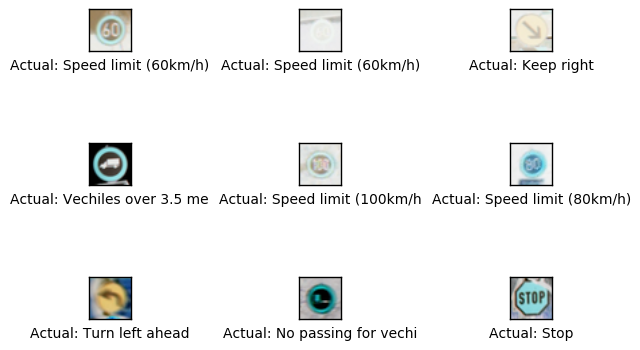

Training_Set_Raw_PPM | validation_set['images'] shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | validation_set['labels'] shape: (3920,)
Training_Set_Raw_PPM | validation_set['filenames'] shape: (3920,)
Training_Set_Raw_PPM | validation_set['num_examples'] shape: 3920


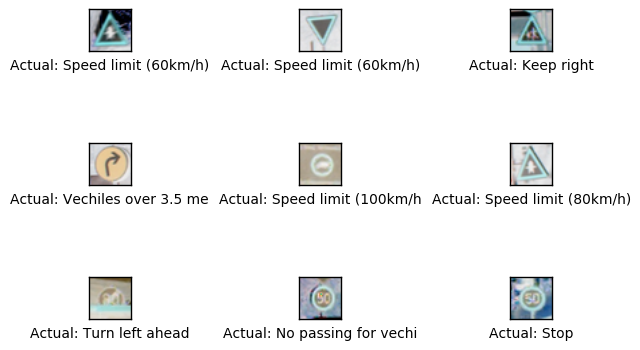

Loading report for Training_Set_Raw_PPM concluded.

Dataset: " Testing_Set_Raw_PPM " successfully loaded to memory location: <__main__.DataSet object at 0x7f9927ab4908>
Testing_Set_Raw_PPM | Images tensor shape: (12630, 32, 32, 3)
Testing_Set_Raw_PPM | Labels vector length: (12630,)
Testing_Set_Raw_PPM | Number of image filenames vector length: (12630,)
Testing_Set_Raw_PPM | Number of classified labelnames vector length: (43, 2)
Testing_Set_Raw_PPM | Number of image examples in the set: 12630


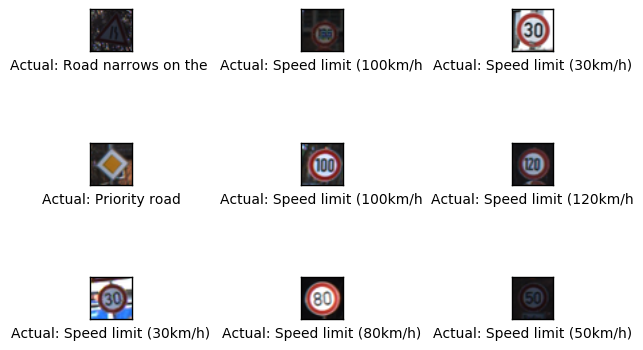

Loading report for Testing_Set_Raw_PPM concluded.


In [5]:
#Load Datasets
training_set, testing_sets = DataSet.load_datasets(use_raw_dataset=True, refresh_datacache=True)


----

### Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

## Architecture

### Helper Class: <font color='green'> Batch Normalization</font>

In [6]:
class batch_norm(object):
    def __init__(self, batch_size, epsilon=1e-5, momentum = 0.1, name="batch_norm"):
        with tf.variable_scope(name) as scope:
            try:
                self.epsilon = epsilon
                self.momentum = momentum
                self.batch_size = batch_size

                self.ema = tf.train.ExponentialMovingAverage(decay=self.momentum)
                self.name=name
            except ValueError:
                scope.reuse_variables()
                self.epsilon = tf.get_variable('epsilon')
                self.momentum = tf.get_variable('momentum')
                self.batch_size = tf.get_variable('batch_size')
                self.ema = tf.train.ExponentialMovingAverage(decay=self.momentum)
                self.name = tf.get_variable('name')
    #TODO: Add report_hyperparamters method.

    def __call__(self, x, train=True):
        shape = x.get_shape().as_list()

        with tf.variable_scope(self.name) as scope:
            try:
                self.gamma = tf.get_variable("gamma", [shape[-1]],
                            initializer=tf.random_normal_initializer(1., 0.02))
                self.beta = tf.get_variable("beta", [shape[-1]],
                            initializer=tf.constant_initializer(0.))
                self.mean, self.variance = tf.nn.moments(x, [0, 1, 2])
            except ValueError:
                scope.reuse_variables()
                self.gamma = tf.get_variable("gamma")
                self.beta = tf.get_variable("beta")
                self.mean, self.variance = tf.nn.moments(x, [0, 1, 2])

            return tf.nn.batch_norm_with_global_normalization(
                   x, self.mean, self.variance, self.beta, self.gamma, self.epsilon,
                   scale_after_normalization=True)

In [7]:
def lrelu(x, leak=0.2, name="leaky_relu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)
        
def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):        
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "Linear")as scope:
            try:
                matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                         tf.random_normal_initializer(stddev=stddev))
                bias = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(bias_start))
            except ValueError:  
                scope.reuse_variables()
                matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                         tf.random_normal_initializer(stddev=stddev))
                bias = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(bias_start))
        
    if with_w:
        return tf.matmul(input_, matrix) + bias, matrix, bias
    else:
        return tf.matmul(input_, matrix) + bias

def conv2d(input_, output_dim,
           filter_size=5, strides=2, stddev=0.02,
           name="conv2d"):
    with tf.variable_scope(name) as scope:
        try:
            w = tf.get_variable('w', [filter_size, filter_size, input_.get_shape()[-1], output_dim],
                        initializer=tf.truncated_normal_initializer(stddev=stddev))
        except ValueError:
            scope.reuse_variables()
            w = tf.get_variable('w', [filter_size, filter_size, input_.get_shape()[-1], output_dim],
                        initializer=tf.truncated_normal_initializer(stddev=stddev))
                
        conv = tf.nn.conv2d(input_, w, strides=[1, strides, strides, 1], padding='SAME')
        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())
        return conv

##### <font color='red'> Question 3 - Done</font> ###


**_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.) For reference on how to build a deep neural network using TensorFlow, see Deep Neural Network in TensorFlow from the classroom._**

** <font color='blue'> Answer:</font>**
flattened_image, num_features: Tensor("Reshape:0", shape=(100, 3072), dtype=float32) 3072
d_h_0_linear output: Tensor("add:0", shape=(100, 1024), dtype=float32)
d_h0_conv: Tensor("leaky_relu/add:0", shape=(100, 16, 16, 32), dtype=float32)
d_h1_conv: Tensor("leaky_relu_1/add:0", shape=(100, 8, 8, 64), dtype=float32)
d_h2_conv: Tensor("leaky_relu_2/add:0", shape=(100, 4, 4, 128), dtype=float32)
d_h3_conv: Tensor("leaky_relu_3/add:0", shape=(100, 2, 2, 256), dtype=float32)
flattened_layer, num_features: Tensor("Reshape_2:0", shape=(100, 1024), dtype=float32) 1024
d_h4_linear output: Tensor("add_1:0", shape=(100, 43), dtype=float32)

### Model

In [8]:
class Model():
    def __init__(self, batch_size=100, x_dim = DEFAULT_LENGTH, y_dim = DEFAULT_WIDTH, learning_rate= 0.9e-5, conv_depth = 32, num_classes=43):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.conv_depth = conv_depth

        # tf Graph batch of image (batch_size, height, width, depth)
        self.batch = tf.placeholder(tf.float32, [batch_size, x_dim, y_dim, DEFAULT_DEPTH], name="batch")
        self.batch_labels = tf.placeholder(tf.float32, [batch_size, self.num_classes], name="batch_labels") # dataset labels for the batch

        # batch normalization : deals with poor initialization helps gradient flow
        self.d_bn1 = batch_norm(batch_size, name='d_bn1')
        self.d_bn2 = batch_norm(batch_size, name='d_bn2')
        self.d_bn3 = batch_norm(batch_size, name='d_bn3')

        self.predict = self.discriminator(self.batch)
        self.cost = tf.reduce_mean(-tf.reduce_sum(self.batch_labels * tf.log(self.predict), reduction_indices=[1]))
        correct_prediction = tf.equal(tf.argmax(self.predict,1), tf.argmax(self.batch_labels,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost)

        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        self.saver = tf.train.Saver(tf.all_variables())
        
    def flatten_layer(self, layer):
        # Get the shape of the input layer.
        layer_shape = layer.get_shape()

        # The shape of the input layer is assumed to be:
        # layer_shape == [num_images, img_height, img_width, num_channels]

        # The number of features is: img_height * img_width * num_channels
        # Function from TensorFlow is used to calculate this.
        num_features = layer_shape[1:4].num_elements()

        # Reshape the layer to [num_images, num_features].
        # Note that the size of the second dimension, num_features and the size of the first dimension to -1
        # So the size in that dimension is calculated, and the total size of tensor is unchanged from the reshaping.
        layer_flat = tf.reshape(layer, [-1, num_features])

        return layer_flat, num_features
        
    def discriminator(self, images):
        single_channel_size = DEFAULT_LENGTH*DEFAULT_WIDTH
        #Convert Feed Image into Linear Layer to give each pixel a weight        
        flattened_image, num_features = self.flatten_layer(images)
        print("Building Discriminator:\nflattened_image, num_features:",flattened_image, num_features)
        h_0 = linear(flattened_image, single_channel_size, 'd_h_0_linear')
        print("d_h_0_linear output:", h_0)
        
        #4 Convolution Layers
        h0 = lrelu(conv2d(tf.reshape(images, [-1, DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH]), 
                          self.conv_depth, name='d_h0_conv'))
        print("d_h0_conv:", h0)
        h1 = lrelu(self.d_bn1(conv2d(h0, self.conv_depth*2, name='d_h1_conv')))
        print("d_h1_conv:", h1)
        h2 = lrelu(self.d_bn2(conv2d(h1, self.conv_depth*4, name='d_h2_conv')))
        print("d_h2_conv:", h2)
        h3 = lrelu(self.d_bn3(conv2d(h2, self.conv_depth*8, name='d_h3_conv')))
        print("d_h3_conv:", h3)
        
        #Feed Output of Conv into Fully-Connected Linear Layer to map to Num_Classes
        flattened_layer, num_features = self.flatten_layer(h3)
        print("flattened_layer, num_features:", flattened_layer, num_features)
        h4 = linear(flattened_layer, self.num_classes, 'd_h4_linear')
        print("d_h4_linear output:", h4,"\n")

        #Softmax to Normalize
        return tf.nn.softmax(h4)
    
    
    def to_one_hot(self, labels):
        # convert labels, a numpy list of labels (of size batch_size) to the one hot equivalent
        return np.eye(self.num_classes)[labels]
    
    def partial_train(self, batch, labels):
        _, cost, accuracy = self.sess.run((self.train_op, self.cost, self.accuracy),
                              feed_dict={self.batch: batch, self.batch_labels: self.to_one_hot(labels)})
        return cost, accuracy
    
    def classify_test_set(self, testing_set, show_example_errors=True,
                            show_confusion_matrix=False):        
        # Allocate an prediction array for the classes, which will be calculated in batches and filled into prediction.
        prediction = np.zeros(shape=testing_set.num_examples, dtype=np.int)
        testing_set.shuffle_data()
        total_batch = int(testing_set.num_examples / self.batch_size)

        # Loop over all batches
        for i in range(total_batch):
            #Because bothe the training and test set are utilizing the same tf session, I use the same batch_size
            batch_images, batch_labels = testing_set.next_batch(self.batch_size, with_label = True)
            one_hot_batch_labels = self.to_one_hot(batch_labels)
            
            # Get the correct batch of testing examples.
            batch_start = (i)*self.batch_size
            batch_end = min((i+1)*self.batch_size, testing_set.num_examples)
            
            # Create a feed-dict with these images and labels.
            feed_dict={self.batch: batch_images, self.batch_labels: one_hot_batch_labels}

            # Calculate the predicted class using TensorFlow.
            prediction[batch_start:batch_end] = self.sess.run(tf.argmax(self.predict, dimension=1),
                                                            feed_dict=feed_dict)

        # Create a boolean array whether each image is correctly classified.
        correct_prediction = (testing_set.labels == prediction)

        # Calculate the number of correctly classified images.
        correct_sum = np.sum(correct_prediction)

        # Classification accuracy is the number of correctly classified
        accuracy = correct_sum / testing_set.num_examples

        msg = "\n\nAccuracy on {3}: {0:.1%} ({1} / {2})"
        print(msg.format(accuracy, correct_sum, testing_set.num_examples, testing_set.name))

        if show_example_errors:
            # Plot some examples of mis-classifications
            print("Example errors:")
            plot_example_errors(cls_pred=prediction, correct=correct_prediction, testing_set=testing_set)

        if show_confusion_matrix:
            # Plot the confusion matrix, if desired.
            print("Confusion Matrix:")
            plot_confusion_matrix(cls_pred=prediction, testing_set=testing_set) 
        return accuracy
    
    def save_model(self, checkpoint_path, epoch):
        if not os.path.exists(checkpoint_path):
            os.mkdir(checkpoint_path)
        self.saver.save(self.sess, checkpoint_path, global_step = epoch)
        
    def close_session(self):
        self.sess.close()

    def load_model(self, checkpoint_path):
        ckpt = tf.train.get_checkpoint_state(checkpoint_path)
        print("loading model: ",ckpt.model_checkpoint_path)
        self.saver.restore(self.sess, ckpt.model_checkpoint_path)

### Helper-function: <font color='green'> Plot Example Errors</font> ###
Function for plotting examples of images from the test-set that have been mis-classified.

In [9]:
def plot_example_errors(cls_pred, correct, testing_set):
    # cls_pred is an array of the predicted class-number for all images in the test-set.
    # correct is a boolean array whether the predicted class is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been incorrectly classified.
    images = testing_set.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true_test = testing_set.labels[incorrect]
    
    # Plot the first 9 images.
    testing_set.plot_images(cls_pred=cls_pred[0:9])

### Helper-function: <font color='green'> Plot Confusion Matrix</font> ###

In [10]:
def plot_confusion_matrix(cls_pred, testing_set):    
    n_classes = testing_set.num_examples
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true_test = testing_set.labels
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true_test,
                          y_pred=cls_pred)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Auto Train/Optimize for Performance
This section deals with the Tensorflow session and running the Tensorflow graph to optimize the model. If the validation_set is used (default) the num_epochs will be inreased and be provided only as a catch-all, otherwise the optimization finishes when the validation_accuracy has not improved after a configurable number of iterations. The cost (loss), and resulting accuracy of the discriminator are printed as auto-optimization occurs. 

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The progress reports are printed after every:
    - training epoch
    - validation classification
    - test set classification

### Helper-function: <font color='green'> Optimization Instructor</font> ###
There are rougly 40,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. I therefore only use a small batch of images in each iteration of the optimizer. If the validation_set is desired, it can be specific by setting the valiation_portion= 0.xx. Default is 10%

In [11]:
def optimize(training_set, testing_sets, num_epochs=12, early_stop=True):
    global best_validation_accuracy
    global last_improvement
    
    #Set the epochs value high to try to trigger early_stop conditions.
    if early_stop:
        num_epochs = 50

    # Start-time used for printing time-usage below.
    start_time = time.time()
    model = Model()
    
    batch_size = model.batch_size
    num_examples = training_set.num_examples
    training_epochs = num_epochs
    checkpoint_path = os.path.join(DATASET_DIRECTORY, DATACACHE_DIRECTORY, 'model.ckpt')

    # load previously trained model if appilcable
    ckpt = tf.train.get_checkpoint_state(DATACACHE_DIRECTORY)
    if ckpt:
        model.load_model(DATACACHE_DIRECTORY)
        
    #Classify before any optimization:
    for testing_set in testing_sets:
        model.classify_test_set(testing_set=testing_set)
        
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        avg_accuracy = 0.
        training_set.shuffle_data()
        total_batch = int(num_examples / batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_images, batch_labels = training_set.next_batch(batch_size, with_label = True)
            cost, accuracy = model.partial_train(batch_images, batch_labels)

            assert( cost == cost and not math.isinf(cost)) # make sure it is not NaN or Inf
            assert( accuracy == accuracy and not math.isinf(accuracy)) # make sure it is not NaN or Inf

            # Display logs per epoch step
            if (i % 100 == 0):
                print("epoch:", '%04d' % (epoch),
                      "mini-batch iteration:", '%04d' % (i), 
                      "cost=", "{:.6f}".format(cost),
                        "accuracy=", "{:.6f}".format(accuracy))

            # Compute average loss
            avg_cost += cost / num_examples * batch_size
            avg_accuracy += accuracy / num_examples * batch_size

        # Display logs per epoch step
        print("epoch:", '%04d' % (epoch), 
              "avg_cost=", "{:.6f}".format(avg_cost), 
              "avg_accuracy=", "{:.6f}".format(avg_accuracy),
              "\n")
        
        # Classifiy Validtion Set
        training_set.set_training_accuracy(avg_accuracy)        
        validation_accuracy = training_set.validation_accuracy
        validation_set = DataSet(images=training_set.validation_set['images'],
                                 labels=training_set.validation_set['labels'],
                                 filenames=training_set.validation_set['filenames'],
                                 labelnames=training_set.labelnames,
                                name="{} | Validation_Set".format(training_set.name))
        training_set.set_validation_accuracy(model.classify_test_set(testing_set=validation_set,
                                                                     show_example_errors=False))
            
        if training_set.validation_accuracy > best_validation_accuracy:
                # Update the best-known validation accuracy.
                best_validation_accuracy = training_set.validation_accuracy

                # Set the iteration for the last improvement to current.
                last_improvement = int(training_set.epochs_completed*(training_set.num_examples/batch_size))

                # A string to be printed below, shows improvement found.
                improved_str = '**'

                #TODO: Save model variables
        elif training_set.validation_accuracy > validation_accuracy:
            improved_str = '*'
        else:
            # An empty string to be printed below shows that no improvement was found.
            improved_str = ''

            total_iterations = int(training_set.epochs_completed*(training_set.num_examples/batch_size))
            if (training_set.validation_accuracy < validation_accuracy) and \
            (total_iterations - last_improvement) > require_improvement:
                print("No improvement found in a while, stopping optimization.")
                # Break out from the for-loop.
                break

        # Status-message for printing.
        msg = "Iter: {0:>6}, Train-Batch Avg Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%} {3}"
        print(msg.format(last_improvement, training_set.avg_training_accuracy,
                         training_set.validation_accuracy, improved_str))
    # save model every 1 epochs
    if epoch >= 0 and epoch % 1 == 0:
        model.save_model(checkpoint_path, epoch)
        print("model saved to {}".format(checkpoint_path))
    
    #Testing Cycle
    print("Finished Training with training_set/validation_set, now test against testing_set after optimization.")
    for testing_set in testing_sets:
        _ = model.classify_test_set(testing_set=testing_set)
    
    # save model one last time, under zero label to denote finish.
    model.save_model(checkpoint_path, 0)
    
    # Ending time.http://localhost:8157/notebooks/Traffic_Signs_Recognition.ipynb#
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    

##### <font color='red'> Question 4 - Done</font> ###

**_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_**


** <font color='blue'> Answer:</font> ** I used an AdamOptimizer (I beieve this is the SOTA) with a batch_size of 100, utilizing mini-batch. My default number of epochs is 20, but this is because my optimization stops under certain conditions. Note the optimization process explanation below for more details.

##### <font color='red'> Question 5 - Done</font> ###


**_What approach did you take in coming up with a solution to this problem?_**

** <font color='blue'> Answer:</font> ** I spent quite a lot of time studying how Deep Neural Networks work. I had a broad understanding but I chose this project to really dig in and get a "deep" understanding of these architectures. Before beginning the project, I took the Stanford CS231N online course and tried to learn as much as I can about the state of the art. Upon learning that, I designed my model according to some of those best practices. One key difference is that I wanted to build a network without having to depend on Max pooling (for computing resources), so I investigated an architecture where the pictures are down sampled via the ConvNets.

### Helper-function: <font color='green'> Determine Performance</font> ###
Function for printing the classification accuracy on the test-set.
It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.
Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [12]:
# Best validation accuracy seen so far.
best_validation_accuracy = 0.0

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 500

### Auto-optimization (Early Stopping Enabled)
The classification accuracy is printed before any optimization is run. As will be seen, the predicter is not very good at predicting anything in the test set just yet (1% classification on average). It will not improve much from just 1 optimization iteration, because the learning-rate for the optimizer is set very low. So, in order to optimize the model without overfitting to the Dataset, the optimization includes an early_stop boolean which compares the validation accuray after each successive training epoch.

Building Discriminator:
flattened_image, num_features: Tensor("Reshape:0", shape=(100, 3072), dtype=float32) 3072
d_h_0_linear output: Tensor("add:0", shape=(100, 1024), dtype=float32)
d_h0_conv: Tensor("leaky_relu/add:0", shape=(100, 16, 16, 32), dtype=float32)
d_h1_conv: Tensor("leaky_relu_1/add:0", shape=(100, 8, 8, 64), dtype=float32)
d_h2_conv: Tensor("leaky_relu_2/add:0", shape=(100, 4, 4, 128), dtype=float32)
d_h3_conv: Tensor("leaky_relu_3/add:0", shape=(100, 2, 2, 256), dtype=float32)
flattened_layer, num_features: Tensor("Reshape_2:0", shape=(100, 1024), dtype=float32) 1024
d_h4_linear output: Tensor("add_1:0", shape=(100, 43), dtype=float32) 



Accuracy on Testing_Set_Raw_PPM: 1.7% (213 / 12630)
Example errors:


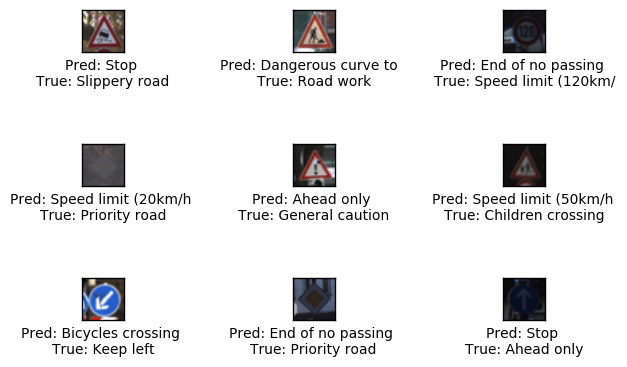



Accuracy on Custom_Testing_Set_Raw_PPM: 3.0% (3 / 100)
Example errors:


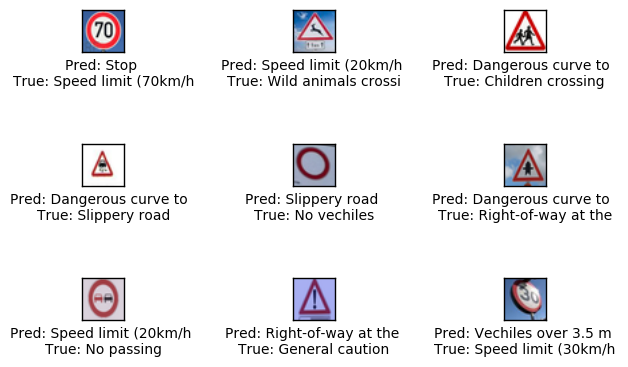

epoch: 0000 mini-batch iteration: 0000 cost= 3.963250 accuracy= 0.020000
epoch: 0000 mini-batch iteration: 0100 cost= 2.977405 accuracy= 0.280000
epoch: 0000 mini-batch iteration: 0200 cost= 2.461241 accuracy= 0.440000
epoch: 0000 mini-batch iteration: 0300 cost= 2.099802 accuracy= 0.550000
epoch: 0000 avg_cost= 2.800563 avg_accuracy= 0.330840 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f99241d73c8>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classified labelnames vector length: (43, 2)
Training_Set_Raw_PPM | Validation_Set | Number of image examples in the set: 3920


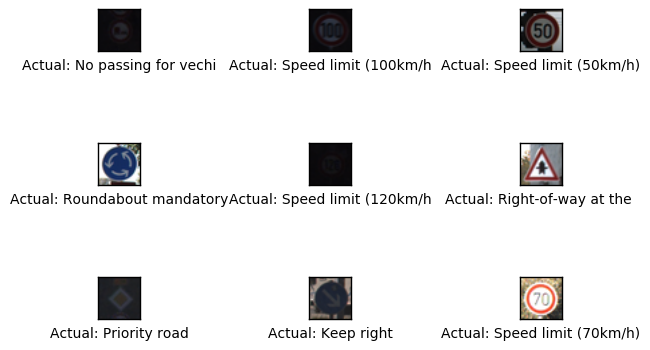

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 50.7% (1988 / 3920)
Iter:      0, Train-Batch Avg Accuracy:  33.1%, Validation Accuracy:  50.7% **
epoch: 0001 mini-batch iteration: 0000 cost= 1.979745 accuracy= 0.510000
epoch: 0001 mini-batch iteration: 0100 cost= 1.847440 accuracy= 0.660000
epoch: 0001 mini-batch iteration: 0200 cost= 1.802063 accuracy= 0.610000
epoch: 0001 mini-batch iteration: 0300 cost= 1.501101 accuracy= 0.670000
epoch: 0001 avg_cost= 1.757162 avg_accuracy= 0.613987 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f992c706dd8>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

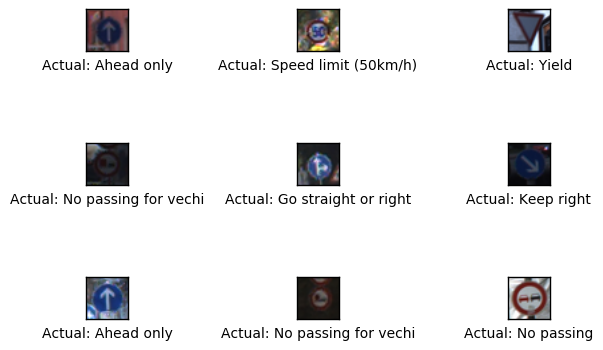

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 69.3% (2718 / 3920)
Iter:    352, Train-Batch Avg Accuracy:  61.4%, Validation Accuracy:  69.3% **
epoch: 0002 mini-batch iteration: 0000 cost= 1.581751 accuracy= 0.600000
epoch: 0002 mini-batch iteration: 0100 cost= 1.288781 accuracy= 0.740000
epoch: 0002 mini-batch iteration: 0200 cost= 1.272044 accuracy= 0.810000
epoch: 0002 mini-batch iteration: 0300 cost= 1.139530 accuracy= 0.810000
epoch: 0002 avg_cost= 1.237644 avg_accuracy= 0.749780 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f991f7d4b00>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

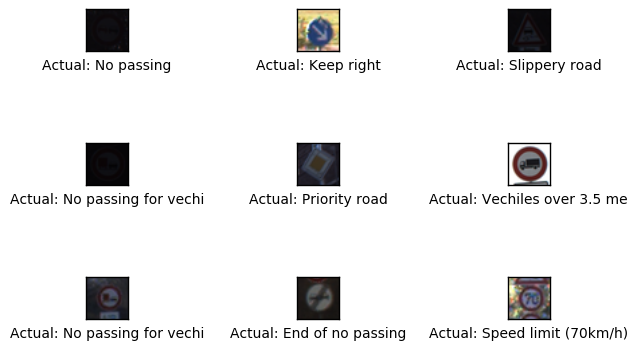

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 78.7% (3085 / 3920)
Iter:    705, Train-Batch Avg Accuracy:  75.0%, Validation Accuracy:  78.7% **
epoch: 0003 mini-batch iteration: 0000 cost= 1.014883 accuracy= 0.880000
epoch: 0003 mini-batch iteration: 0100 cost= 0.978873 accuracy= 0.810000
epoch: 0003 mini-batch iteration: 0200 cost= 0.964762 accuracy= 0.860000
epoch: 0003 mini-batch iteration: 0300 cost= 0.815530 accuracy= 0.880000
epoch: 0003 avg_cost= 0.931406 avg_accuracy= 0.828275 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f9924f1bba8>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

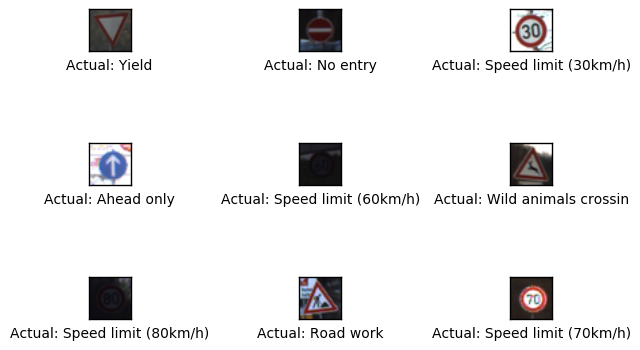

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 83.7% (3282 / 3920)
Iter:   1058, Train-Batch Avg Accuracy:  82.8%, Validation Accuracy:  83.7% **
epoch: 0004 mini-batch iteration: 0000 cost= 0.642794 accuracy= 0.910000
epoch: 0004 mini-batch iteration: 0100 cost= 0.826081 accuracy= 0.860000
epoch: 0004 mini-batch iteration: 0200 cost= 0.677457 accuracy= 0.890000
epoch: 0004 mini-batch iteration: 0300 cost= 0.664206 accuracy= 0.900000
epoch: 0004 avg_cost= 0.733238 avg_accuracy= 0.876505 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f9924e6a550>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

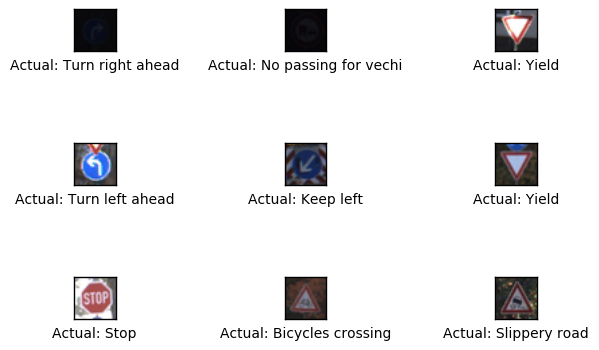

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 86.9% (3406 / 3920)
Iter:   1411, Train-Batch Avg Accuracy:  87.7%, Validation Accuracy:  86.9% **
epoch: 0005 mini-batch iteration: 0000 cost= 0.718095 accuracy= 0.860000
epoch: 0005 mini-batch iteration: 0100 cost= 0.648935 accuracy= 0.910000
epoch: 0005 mini-batch iteration: 0200 cost= 0.561603 accuracy= 0.910000
epoch: 0005 mini-batch iteration: 0300 cost= 0.619657 accuracy= 0.890000
epoch: 0005 avg_cost= 0.596318 avg_accuracy= 0.903766 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f9916d5b4a8>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

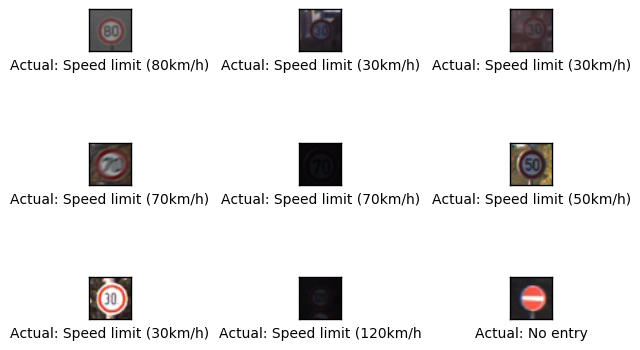

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 89.1% (3492 / 3920)
Iter:   1764, Train-Batch Avg Accuracy:  90.4%, Validation Accuracy:  89.1% **
epoch: 0006 mini-batch iteration: 0000 cost= 0.521643 accuracy= 0.920000
epoch: 0006 mini-batch iteration: 0100 cost= 0.552513 accuracy= 0.920000
epoch: 0006 mini-batch iteration: 0200 cost= 0.504082 accuracy= 0.900000
epoch: 0006 mini-batch iteration: 0300 cost= 0.445545 accuracy= 0.940000
epoch: 0006 avg_cost= 0.495422 avg_accuracy= 0.921874 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f99243b5dd8>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

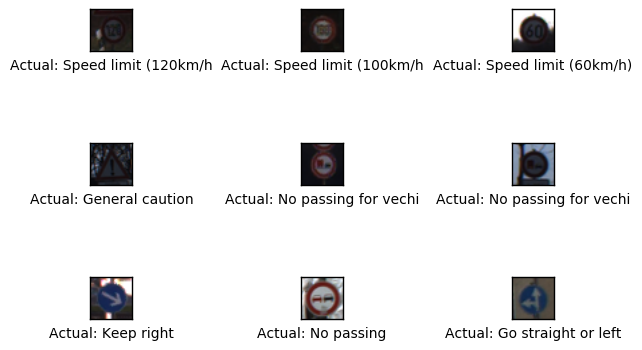

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 90.8% (3560 / 3920)
Iter:   2117, Train-Batch Avg Accuracy:  92.2%, Validation Accuracy:  90.8% **
epoch: 0007 mini-batch iteration: 0000 cost= 0.364796 accuracy= 0.930000
epoch: 0007 mini-batch iteration: 0100 cost= 0.416909 accuracy= 0.940000
epoch: 0007 mini-batch iteration: 0200 cost= 0.461938 accuracy= 0.920000
epoch: 0007 mini-batch iteration: 0300 cost= 0.341379 accuracy= 0.950000
epoch: 0007 avg_cost= 0.418963 avg_accuracy= 0.935419 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f9919a48048>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

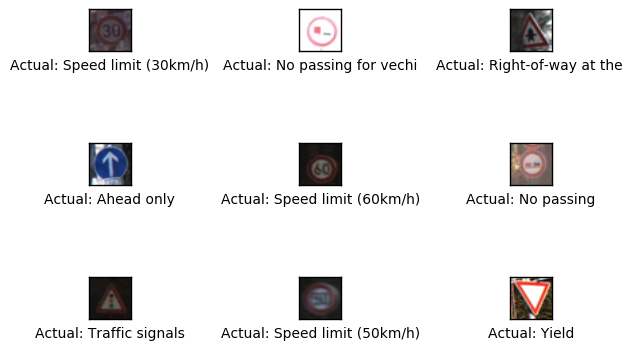

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 92.2% (3613 / 3920)
Iter:   2470, Train-Batch Avg Accuracy:  93.5%, Validation Accuracy:  92.2% **
epoch: 0008 mini-batch iteration: 0000 cost= 0.333696 accuracy= 0.980000
epoch: 0008 mini-batch iteration: 0100 cost= 0.363538 accuracy= 0.920000
epoch: 0008 mini-batch iteration: 0200 cost= 0.463570 accuracy= 0.930000
epoch: 0008 mini-batch iteration: 0300 cost= 0.346252 accuracy= 0.950000
epoch: 0008 avg_cost= 0.359329 avg_accuracy= 0.945082 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f99244dbf98>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

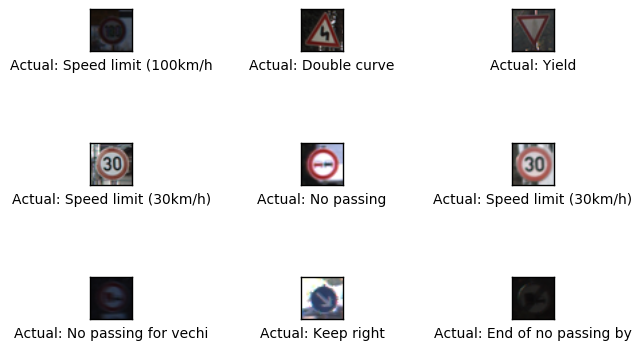

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 92.7% (3633 / 3920)
Iter:   2823, Train-Batch Avg Accuracy:  94.5%, Validation Accuracy:  92.7% **
epoch: 0009 mini-batch iteration: 0000 cost= 0.329038 accuracy= 0.970000
epoch: 0009 mini-batch iteration: 0100 cost= 0.363190 accuracy= 0.980000
epoch: 0009 mini-batch iteration: 0200 cost= 0.325909 accuracy= 0.950000
epoch: 0009 mini-batch iteration: 0300 cost= 0.285827 accuracy= 0.950000
epoch: 0009 avg_cost= 0.311351 avg_accuracy= 0.953612 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f992423fb70>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

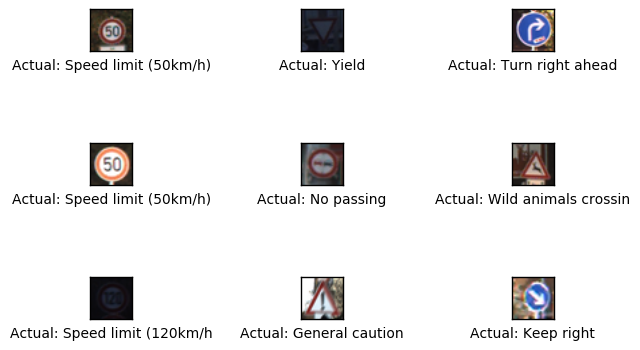

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 93.5% (3667 / 3920)
Iter:   3176, Train-Batch Avg Accuracy:  95.4%, Validation Accuracy:  93.5% **
epoch: 0010 mini-batch iteration: 0000 cost= 0.262998 accuracy= 0.970000
epoch: 0010 mini-batch iteration: 0100 cost= 0.255046 accuracy= 0.990000
epoch: 0010 mini-batch iteration: 0200 cost= 0.249490 accuracy= 0.960000
epoch: 0010 mini-batch iteration: 0300 cost= 0.223683 accuracy= 0.960000
epoch: 0010 avg_cost= 0.271929 avg_accuracy= 0.960243 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f99244e7588>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

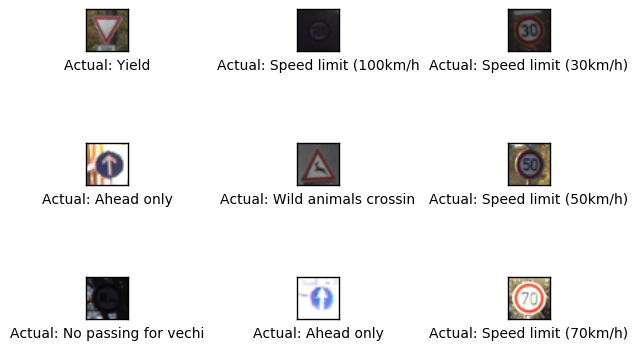

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 93.7% (3673 / 3920)
Iter:   3528, Train-Batch Avg Accuracy:  96.0%, Validation Accuracy:  93.7% **
epoch: 0011 mini-batch iteration: 0000 cost= 0.193198 accuracy= 0.970000
epoch: 0011 mini-batch iteration: 0100 cost= 0.302755 accuracy= 0.960000
epoch: 0011 mini-batch iteration: 0200 cost= 0.276603 accuracy= 0.950000
epoch: 0011 mini-batch iteration: 0300 cost= 0.229783 accuracy= 0.950000
epoch: 0011 avg_cost= 0.239918 avg_accuracy= 0.966052 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f9919a97908>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

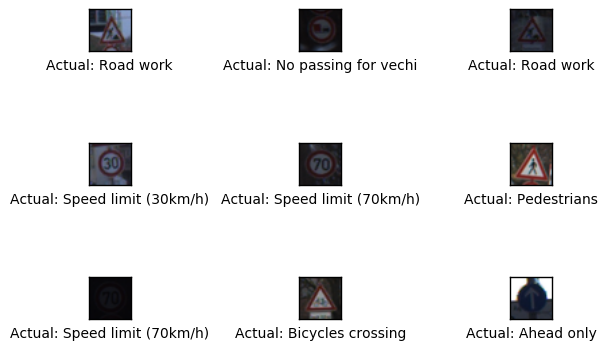

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 94.2% (3693 / 3920)
Iter:   3881, Train-Batch Avg Accuracy:  96.6%, Validation Accuracy:  94.2% **
epoch: 0012 mini-batch iteration: 0000 cost= 0.190787 accuracy= 0.980000
epoch: 0012 mini-batch iteration: 0100 cost= 0.238623 accuracy= 0.980000
epoch: 0012 mini-batch iteration: 0200 cost= 0.204341 accuracy= 0.990000
epoch: 0012 mini-batch iteration: 0300 cost= 0.160112 accuracy= 0.980000
epoch: 0012 avg_cost= 0.213082 avg_accuracy= 0.969367 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f992440b518>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

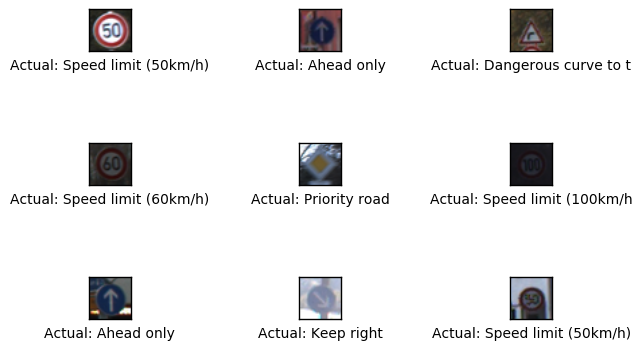

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 94.4% (3701 / 3920)
Iter:   4234, Train-Batch Avg Accuracy:  96.9%, Validation Accuracy:  94.4% **
epoch: 0013 mini-batch iteration: 0000 cost= 0.191544 accuracy= 0.980000
epoch: 0013 mini-batch iteration: 0100 cost= 0.153096 accuracy= 0.990000
epoch: 0013 mini-batch iteration: 0200 cost= 0.179916 accuracy= 0.980000
epoch: 0013 mini-batch iteration: 0300 cost= 0.319659 accuracy= 0.930000
epoch: 0013 avg_cost= 0.189237 avg_accuracy= 0.972994 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f99241b7da0>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

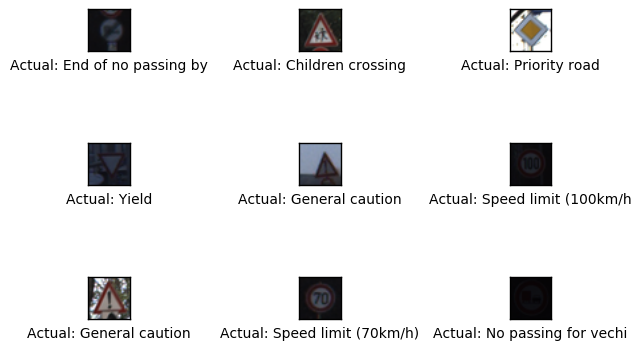

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 94.8% (3717 / 3920)
Iter:   4587, Train-Batch Avg Accuracy:  97.3%, Validation Accuracy:  94.8% **
epoch: 0014 mini-batch iteration: 0000 cost= 0.142254 accuracy= 0.990000
epoch: 0014 mini-batch iteration: 0100 cost= 0.200567 accuracy= 0.990000
epoch: 0014 mini-batch iteration: 0200 cost= 0.113640 accuracy= 1.000000
epoch: 0014 mini-batch iteration: 0300 cost= 0.188628 accuracy= 0.970000
epoch: 0014 avg_cost= 0.169408 avg_accuracy= 0.975573 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f991c8c7b00>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

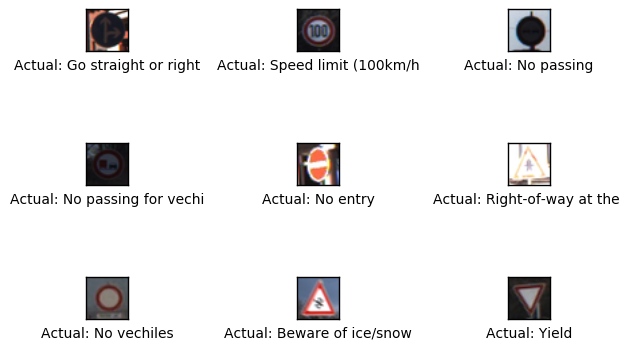

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 95.0% (3724 / 3920)
Iter:   4940, Train-Batch Avg Accuracy:  97.6%, Validation Accuracy:  95.0% **
epoch: 0015 mini-batch iteration: 0000 cost= 0.175584 accuracy= 0.980000
epoch: 0015 mini-batch iteration: 0100 cost= 0.143915 accuracy= 1.000000
epoch: 0015 mini-batch iteration: 0200 cost= 0.122341 accuracy= 1.000000
epoch: 0015 mini-batch iteration: 0300 cost= 0.108734 accuracy= 1.000000
epoch: 0015 avg_cost= 0.151463 avg_accuracy= 0.978634 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f9919a3feb8>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classifi

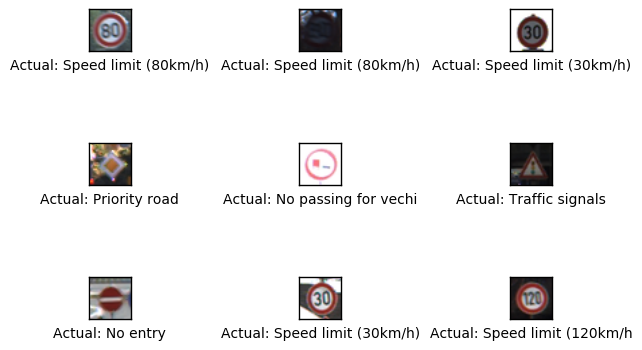

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 94.9% (3722 / 3920)
Iter:   4940, Train-Batch Avg Accuracy:  97.9%, Validation Accuracy:  94.9% 
epoch: 0016 mini-batch iteration: 0000 cost= 0.137990 accuracy= 0.980000
epoch: 0016 mini-batch iteration: 0100 cost= 0.213917 accuracy= 0.960000
epoch: 0016 mini-batch iteration: 0200 cost= 0.149518 accuracy= 0.990000
epoch: 0016 mini-batch iteration: 0300 cost= 0.117917 accuracy= 0.990000
epoch: 0016 avg_cost= 0.137137 avg_accuracy= 0.980674 


Dataset: " Training_Set_Raw_PPM | Validation_Set " successfully loaded to memory location: <__main__.DataSet object at 0x7f991f754780>
Training_Set_Raw_PPM | Validation_Set | Images tensor shape: (3920, 32, 32, 3)
Training_Set_Raw_PPM | Validation_Set | Labels vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of image filenames vector length: (3920,)
Training_Set_Raw_PPM | Validation_Set | Number of classified

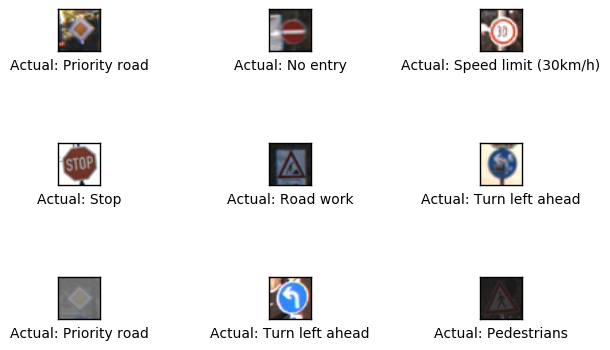

Loading report for Training_Set_Raw_PPM | Validation_Set concluded.


Accuracy on Training_Set_Raw_PPM | Validation_Set: 94.6% (3708 / 3920)
No improvement found in a while, stopping optimization.
model saved to traffic-signs-data/datacache/model.ckpt
Finished Training with training_set/validation_set, now test against testing_set after optimization.


Accuracy on Testing_Set_Raw_PPM: 86.6% (10937 / 12630)
Example errors:


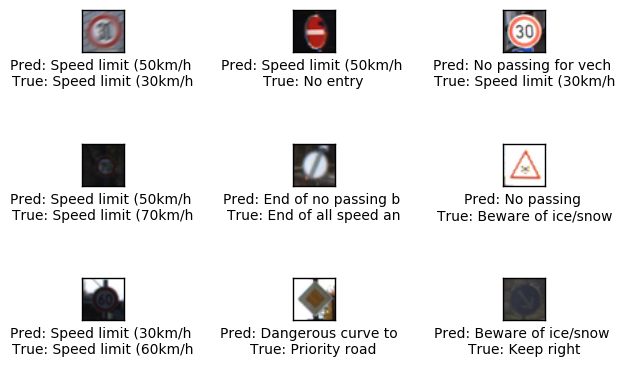



Accuracy on Custom_Testing_Set_Raw_PPM: 50.0% (50 / 100)
Example errors:


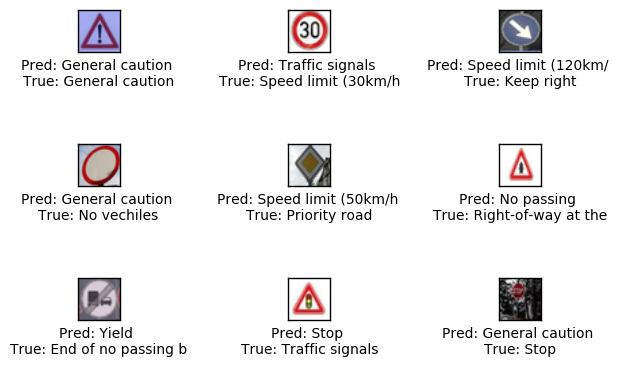

Time usage: 0:11:52


In [13]:
optimize(training_set=training_set, testing_sets=testing_sets, num_epochs=20)

---

### Step 3: Test a Model on <font color='red'> New</font> Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

##### <font color='red'> Question 6 - Done</font> ###

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



** <font color='blue'> Answer:</font> ** See Custom_Test_Set Report above. I used a custom testing_set of 100 images. These images were screen captures of Google images that I found while searching for Euro road signs.  I purposefully selected a very difficult test_set (included in github repo as a zip file). I wanted to test for the classifier's ability to generalize. While my accuracy was not great (50% on average), I believe the network still has much room for growth.
##### New Images are Tested on Model above in the Custom_Testing_Set DataSet object.

##### <font color='red'> Question 7 - Done</font> ###

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


** <font color='blue'> Answer:</font> ** I believe so, I tested my network on two Dataset (preprocessed vs. source images). To accomplish this, my architecture downloads, extracts, and preprocesses all the data from either the Udacity provided link or directly from the GTSRB website. Before loading it into my nueral network model. It is capable of resizing images and with a few tweaks, I could implement cropping as well!

I believe if the video was split into a Dataset of multiple frames for example, I could tweak the input paramters to accept a video stream. As long as the stream can be reshaped to visual images, it can use my architecture. 

##### <font color='red'> Question 8 - Done</font> ###

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [tf.nn.top_k](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)* tf.nn.top_k will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:
##### (5, 6) array
    a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
             0.12789202],
           [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
             0.15899337],
           [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
             0.23892179],
           [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
             0.16505091],
           [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
             0.09155967]])
    Running it through sess.run(tf.nn.top_k(tf.constant(a), k=3)) produces:
    TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
           [ 0.28086119,  0.27569815,  0.18063401],
           [ 0.26076848,  0.23892179,  0.23664738],
           [ 0.29198961,  0.26234032,  0.16505091],
           [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
           [0, 1, 4],
           [0, 5, 1],
           [1, 3, 5],
           [1, 4, 3]], dtype=int32))

Looking just at the first row we get [ 0.34763842,  0.24879643,  0.12789202], you can confirm these are the 3 largest probabilities in a. You'll also notice [3, 0, 5] are the corresponding indices."

** <font color='blue'> Answer:</font> ** 
This visualization makes sense. Here's how I visualize the softmax and top_k:

In [14]:
from IPython.display import Image
Image('softmax_prediction_flowchart.jpeg')

In [15]:
### Softmax and top_k implemented above, please see implementation below
print(""" 
for i in range(total_batch):
     #Because bothe the training and test set are utilizing the same tf session, I use the same batch_size
     batch_images, batch_labels = testing_set.next_batch(self.batch_size, with_label = True)
     one_hot_batch_labels = self.to_one_hot(batch_labels)

     # Get the correct batch of testing examples.
     batch_start = (i)*self.batch_size
     batch_end = min((i+1)*self.batch_size, testing_set.num_examples)

     # Create a feed-dict with these images and labels.
     feed_dict={self.batch: batch_images, self.batch_labels: one_hot_batch_labels}

     # Calculate the predicted class using TensorFlow.
     prediction[batch_start:batch_end] = self.sess.run(tf.argmax(self.predict, dimension=1),
                                                     feed_dict=feed_dict)

# I did not want to using sess.run and build a feed_dict, so I used numpy, 
# # Create a boolean array whether each image is correctly classified.
# correct_prediction = tf.nn.in_top_k(prediction, self.to_one_hot(testing_set.labels), 1)

# # Calculate the number of correctly classified images.
# correct_sum = tf.reduce_sum(tf.cast(correct_prediction, tf.int32))

# # Classification accuracy is the number of correctly classified
# accuracy = correct_sum / testing_set.num_examples

# Create a boolean array whether each image is correctly classified.
correct_prediction = (testing_set.labels == prediction)

# Calculate the number of correctly classified images.
correct_sum = np.sum(correct_prediction)

# Classification accuracy is the number of correctly classified
accuracy = correct_sum / testing_set.num_examples
""")

 
for i in range(total_batch):
     #Because bothe the training and test set are utilizing the same tf session, I use the same batch_size
     batch_images, batch_labels = testing_set.next_batch(self.batch_size, with_label = True)
     one_hot_batch_labels = self.to_one_hot(batch_labels)

     # Get the correct batch of testing examples.
     batch_start = (i)*self.batch_size
     batch_end = min((i+1)*self.batch_size, testing_set.num_examples)

     # Create a feed-dict with these images and labels.
     feed_dict={self.batch: batch_images, self.batch_labels: one_hot_batch_labels}

     # Calculate the predicted class using TensorFlow.
     prediction[batch_start:batch_end] = self.sess.run(tf.argmax(self.predict, dimension=1),
                                                     feed_dict=feed_dict)

# I did not want to using sess.run and build a feed_dict, so I used numpy, 
# # Create a boolean array whether each image is correctly classified.
# correct_prediction = tf.nn.in_top_k(pr

**Example Output of Accuracy:**

In [16]:
print("""
Accuracy on Training_Set_Raw_PPM | Validation_Set: 94.9% (3722 / 3920)
Iter:   4940, Train-Batch Avg Accuracy:  97.9%, Validation Accuracy:  94.9% 
epoch: 0016 mini-batch iteration: 0000 cost= 0.137990 accuracy= 0.980000
epoch: 0016 mini-batch iteration: 0100 cost= 0.213917 accuracy= 0.960000
epoch: 0016 mini-batch iteration: 0200 cost= 0.149518 accuracy= 0.990000
epoch: 0016 mini-batch iteration: 0300 cost= 0.117917 accuracy= 0.990000
epoch: 0016 avg_cost= 0.137137 avg_accuracy= 0.980674
""")


Accuracy on Training_Set_Raw_PPM | Validation_Set: 94.9% (3722 / 3920)
Iter:   4940, Train-Batch Avg Accuracy:  97.9%, Validation Accuracy:  94.9% 
epoch: 0016 mini-batch iteration: 0000 cost= 0.137990 accuracy= 0.980000
epoch: 0016 mini-batch iteration: 0100 cost= 0.213917 accuracy= 0.960000
epoch: 0016 mini-batch iteration: 0200 cost= 0.149518 accuracy= 0.990000
epoch: 0016 mini-batch iteration: 0300 cost= 0.117917 accuracy= 0.990000
epoch: 0016 avg_cost= 0.137137 avg_accuracy= 0.980674



##### <font color='red'> Question 9 - Done</font> ###

_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


** <font color='blue'> Answer:</font> **
- Used this tutorial as a skeleton starting point: https://github.com/Hvass-Labs/TensorFlow-Tutorials
    - I changed the architecture quite substantially, for example, I use more ConvNets and I use leaky relu. 
- Used this online lecture class for theory: https://cs231n.github.io/
    - I learned about the state of the art and modeled my architecture on many of the principles.

###### > **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.